<a href="https://colab.research.google.com/github/dinaelmiari/EEG-Seizures-Detection-using-Classical-and-Deep-Learning-Methods_/blob/main/FINAL_Signal_Pro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install numpy

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
data = np.load("/content/eeg-seizure_val_balanced.npz")

In [ ]:
X = data['val_signals']  # EEG data
y = data['val_labels']  # Labels

In [ ]:
print("EEG shape:", X.shape)
print("Labels shape:", y.shape)
print("Unique labels:", np.unique(y))

EEG shape: (3546, 23, 256)
Labels shape: (3546,)
Unique labels: [0 1]


We applied PCA on our EEG dataset, which consisted of 3546 trials with 23 electrodes and 256 time points each, reshaped into a 2D format of 3546 × 5888.

After standardizing the data, PCA was performed. The cumulative explained variance plot showed that 302 principal components were sufficient to explain 90% of the variance in the data. This

**A1**

**This code performs Principal Component Analysis (PCA) on EEG data to identify how many components are needed to retain 90% of the variance. First, it reshapes the EEG dataset from a 3D array of shape (3546 samples, 23 channels, 256 time points) into a 2D array (3546, 5888) to make it suitable for PCA. The data is then standardized using StandardScaler to ensure that all features contribute equally. PCA is applied to the standardized data, and the cumulative explained variance is calculated and plotted to show how much variance is captured as more components are included. A red dashed line marks the 90% variance threshold, and the code determines and prints the number of principal components needed to reach this threshold which is 302**

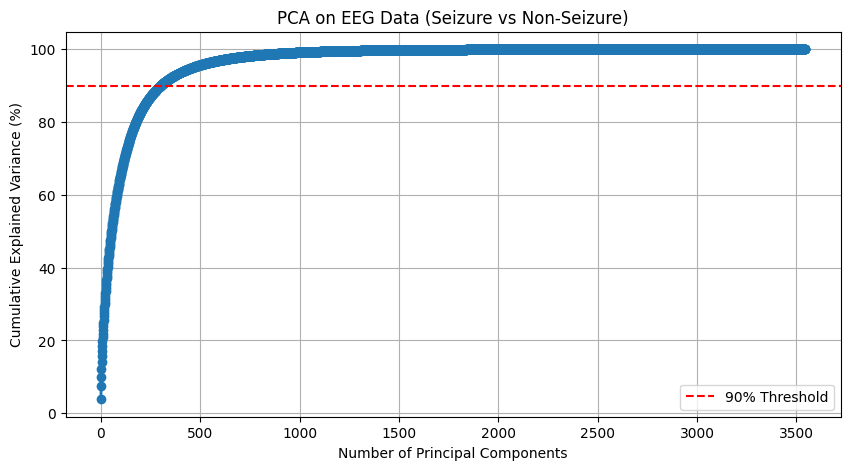

Components needed for 90% variance: 302


In [ ]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Reshape EEG from (3546, 23, 256) → (3546, 23*256)
X_reshaped = X.reshape(X.shape[0], -1)  # shape: (3546, 5888)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_reshaped)

# Apply PCA
pca = PCA()
pca.fit(X_scaled)

# Calculate cumulative explained variance
explained_variance = np.cumsum(pca.explained_variance_ratio_) * 100

# Plot
plt.figure(figsize=(10, 5))
plt.plot(explained_variance, marker='o', linewidth=2)
plt.axhline(90, color='red', linestyle='--', label='90% Threshold')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance (%)')
plt.title('PCA on EEG Data (Seizure vs Non-Seizure)')
plt.grid(True)
plt.legend()
plt.show()

# Components needed for 90% variance
num_components = np.argmax(explained_variance >= 90) + 1
print(f"Components needed for 90% variance: {num_components}")



**A2a**

**This code visualizes the first two principal components (PC1 and PC2) obtained from PCA applied to EEG data. Each principal component is initially a 1D array of length 5888 (flattened form of 23 channels × 256 timepoints), so the code reshapes them back to a 2D matrix of shape (23, 256) to reflect the spatial (electrode/channel) and temporal structure of the EEG signals. Using plt.imshow, it then plots heatmaps of PC1 and PC2, with the x-axis representing time and the y-axis representing EEG channels. The color intensity in the heatmaps reflects the contribution (loading) of each channel-timepoint pair to the respective principal component, helping to interpret which regions (channels and time windows) are most influential in the variance captured by PC1 and PC2**

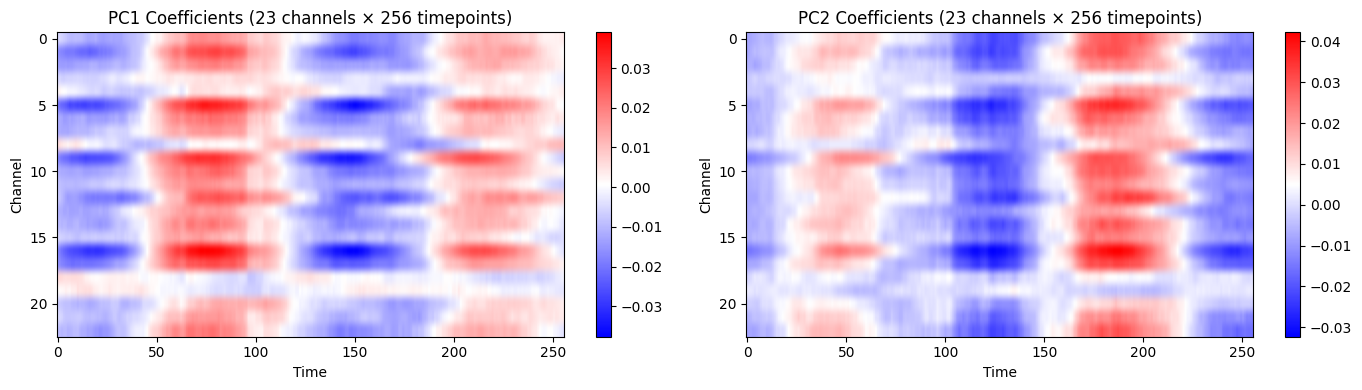

In [ ]:
# Get the first 2 principal components
pc1 = pca.components_[0]  # shape (5888,)
pc2 = pca.components_[1]

# Reshape to (23, 256) for electrode × time view
pc1_reshaped = pc1.reshape(23, 256)
pc2_reshaped = pc2.reshape(23, 256)

# Plot PC1 and PC2
plt.figure(figsize=(14, 4))

plt.subplot(1, 2, 1)
plt.imshow(pc1_reshaped, aspect='auto', cmap='bwr')
plt.title('PC1 Coefficients (23 channels × 256 timepoints)')
plt.colorbar()
plt.xlabel('Time')
plt.ylabel('Channel')

plt.subplot(1, 2, 2)
plt.imshow(pc2_reshaped, aspect='auto', cmap='bwr')
plt.title('PC2 Coefficients (23 channels × 256 timepoints)')
plt.colorbar()
plt.xlabel('Time')
plt.ylabel('Channel')

plt.tight_layout()
plt.show()



We visualized the coefficients of the first two principal components (PC1 and PC2) as 2D maps by reshaping them into their original form: 23 EEG channels* 256 timepoints.

These heatmaps reveal spatio-temporal patterns in the EEG recordings that contribute most to the variance in the data. Notably:

PC1 shows oscillatory patterns in the mid and lower channels around 50-150 ms and 180-230 ms.

PC2 emphasizes temporal regions around 100-200 ms across several channels.

**A2b**

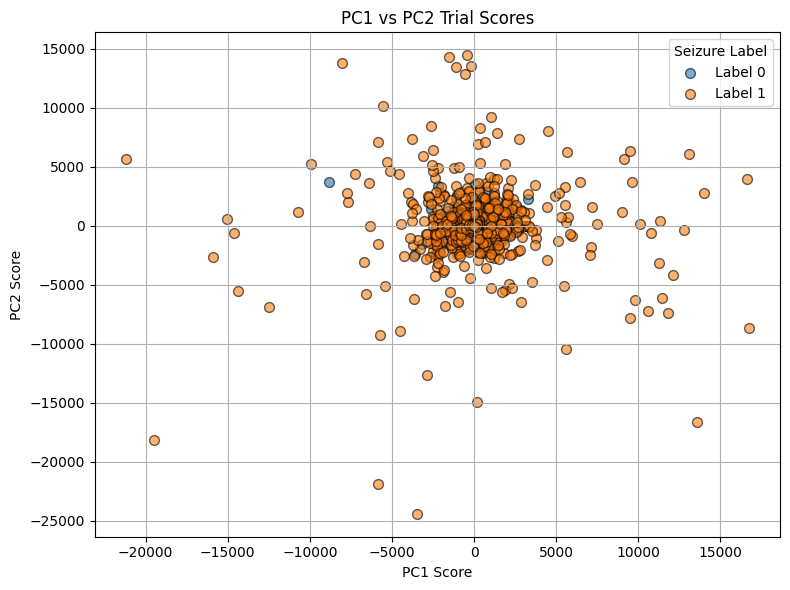

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# 1. Flatten trials
n_trials, n_channels, n_timepoints = X.shape
X_flat = X.reshape(n_trials, n_channels * n_timepoints)  # shape: (3546, 5888)

# 2. PCA
pca = PCA(n_components=2)
scores = pca.fit_transform(X_flat)  # shape: (3546, 2)

# 3. Plot
plt.figure(figsize=(8, 6))
for label in np.unique(y):
    plt.scatter(scores[y == label, 0], scores[y == label, 1],
                label=f'Label {label}', alpha=0.6, edgecolor='k', s=50)

plt.xlabel('PC1 Score')
plt.ylabel('PC2 Score')
plt.title('PC1 vs PC2 Trial Scores')
plt.legend(title='Seizure Label')
plt.grid(True)
plt.tight_layout()
plt.show()


We projected each trial onto the first two principal components (PC1 and PC2) and plotted the scores, colored by the seizure label (0 = non-seizure, 1 = seizure).

The resulting scatter plot shows a large overlap between the two classes. While PC1 and PC2 capture the largest variance in the EEG signals, they do not clearly separate seizure from non-seizure trials in this 2D space. This suggests that:

The top 2 PCs may not encode the most discriminatory features.

Additional PCs or a nonlinear projection might be needed.

**A3**

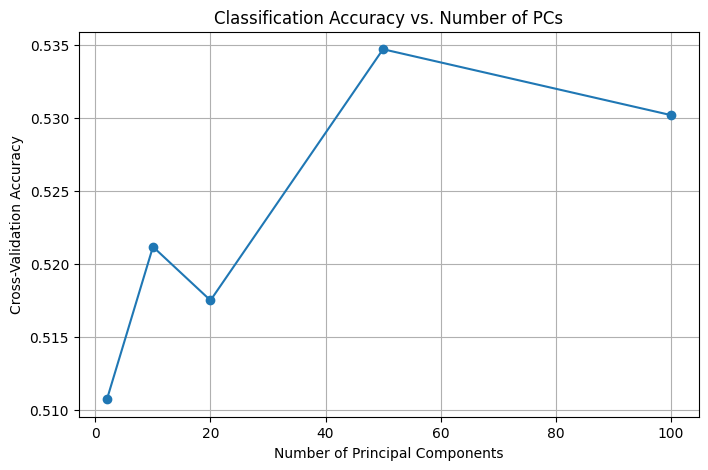

In [ ]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

n_components_list = [2, 10, 20, 50, 100]
accuracies = []

for n in n_components_list:
    pca = PCA(n_components=n)
    X_pca = pca.fit_transform(X_flat)

    clf = LogisticRegression(max_iter=1000)
    scores = cross_val_score(clf, X_pca, y, cv=5)  # 5-fold CV
    accuracies.append(scores.mean())

# Plot
plt.figure(figsize=(8, 5))
plt.plot(n_components_list, accuracies, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cross-Validation Accuracy')
plt.title('Classification Accuracy vs. Number of PCs')
plt.grid(True)
plt.show()


We evaluated the discriminability of seizure vs. non-seizure EEG trials using a logistic regression classifier trained on increasing numbers of principal components (PCs). The classification accuracy using 5-fold cross-validation is shown in the figure.

The accuracy increases slightly from ~51% to ~53.5% as more PCs are added, indicating that seizure-related information is weakly present in the PCA-transformed space. However, the improvement is modest and remains close to chance level (50%), which suggests:

PCA captures variance but not necessarily discriminative variance.

Early PCs focus more on global signal structure than seizure-specific features.

Discriminatory features may lie in higher-order PCs or nonlinear patterns.

**B**

**The proposed method enhances seizure detection by leveraging the spatial relationships between EEG channels through covariance matrices, rather than relying on raw EEG signals. For each trial, a 23×23 covariance matrix is computed to capture the inter-channel correlations, which are then vectorized and reduced using Principal Component Analysis (PCA). The resulting principal components serve as input features to a Support Vector Machine (SVM) classifier, evaluated via 5-fold cross-validation using the AUC metric. The results show a clear improvement in performance, with AUC steadily increasing as more principal components are used, reaching approximately 0.763 with 20 components.**

Covariance + PCA + SVM AUC = 0.724 with 1 PCs
Covariance + PCA + SVM AUC = 0.705 with 2 PCs
Covariance + PCA + SVM AUC = 0.708 with 3 PCs
Covariance + PCA + SVM AUC = 0.713 with 4 PCs
Covariance + PCA + SVM AUC = 0.721 with 5 PCs
Covariance + PCA + SVM AUC = 0.725 with 6 PCs
Covariance + PCA + SVM AUC = 0.725 with 7 PCs
Covariance + PCA + SVM AUC = 0.727 with 8 PCs
Covariance + PCA + SVM AUC = 0.728 with 9 PCs
Covariance + PCA + SVM AUC = 0.735 with 10 PCs
Covariance + PCA + SVM AUC = 0.735 with 11 PCs
Covariance + PCA + SVM AUC = 0.735 with 12 PCs
Covariance + PCA + SVM AUC = 0.735 with 13 PCs
Covariance + PCA + SVM AUC = 0.734 with 14 PCs
Covariance + PCA + SVM AUC = 0.740 with 15 PCs
Covariance + PCA + SVM AUC = 0.744 with 16 PCs
Covariance + PCA + SVM AUC = 0.749 with 17 PCs
Covariance + PCA + SVM AUC = 0.755 with 18 PCs
Covariance + PCA + SVM AUC = 0.754 with 19 PCs
Covariance + PCA + SVM AUC = 0.764 with 20 PCs


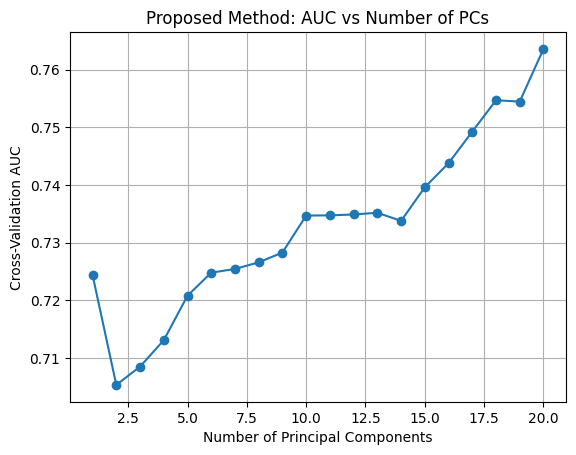

In [ ]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

# Assuming your data is:
# X: shape (3546, 23, 256)
# y: shape (3546,)

def vectorize_cov_upper(trial):
    """Returns upper triangle (excluding diagonal) of covariance matrix."""
    cov = np.cov(trial)
    idx = np.triu_indices_from(cov, k=1)  # upper triangle without diagonal
    return cov[idx]

# Step 1: Covariance feature extraction
X_cov_feats = np.array([vectorize_cov_upper(trial) for trial in X])

def evaluate_paper_method(X_features, y, max_pc=20):
    aucs = []
    for n_pc in range(1, max_pc + 1):
        pca = PCA(n_components=n_pc)
        X_pca = pca.fit_transform(X_features)

        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        fold_aucs = []
        for train_idx, test_idx in skf.split(X_pca, y):
            clf = SVC(kernel='rbf', probability=True)
            clf.fit(X_pca[train_idx], y[train_idx])
            y_score = clf.predict_proba(X_pca[test_idx])[:, 1]
            auc = roc_auc_score(y[test_idx], y_score)
            fold_aucs.append(auc)

        mean_auc = np.mean(fold_aucs)
        aucs.append(mean_auc)
        print(f"Covariance + PCA + SVM AUC = {mean_auc:.3f} with {n_pc} PCs")

    return aucs

# Run the evaluation
paper_aucs = evaluate_paper_method(X_cov_feats, y, max_pc=20)

# Plotting
plt.plot(range(1, 21), paper_aucs, marker='o')
plt.title("Proposed Method: AUC vs Number of PCs")
plt.xlabel("Number of Principal Components")
plt.ylabel("Cross-Validation AUC")
plt.grid(True)
plt.show()


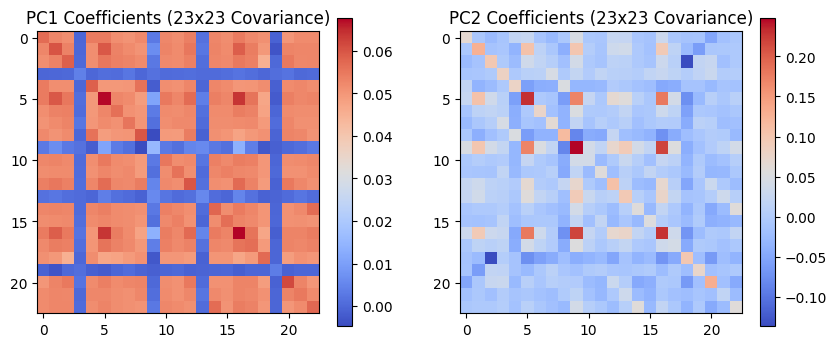

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Flatten covariance matrices into vectors (3546, 23*23)
X_cov = np.array([np.cov(trial) for trial in X])  # (3546, 23, 23)
X_cov_flat = X_cov.reshape(X_cov.shape[0], -1)    # (3546, 529)

# Apply PCA
pca = PCA(n_components=2)
pca.fit(X_cov_flat)

# Extract and reshape PC1 and PC2 coefficients
pc1 = pca.components_[0].reshape(23, 23)
pc2 = pca.components_[1].reshape(23, 23)

# Plot as heatmaps
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
im1 = axs[0].imshow(pc1, cmap='coolwarm')
axs[0].set_title("PC1 Coefficients (23x23 Covariance)")
plt.colorbar(im1, ax=axs[0])

im2 = axs[1].imshow(pc2, cmap='coolwarm')
axs[1].set_title("PC2 Coefficients (23x23 Covariance)")
plt.colorbar(im2, ax=axs[1])
plt.show()


**This figure presents heatmaps of the first two principal component (PC) coefficients computed from the 23×23 covariance matrices of EEG channels for each trial. In the left heatmap, the PC1 coefficients show strong, consistent positive contributions (in red) across many channel pairs, indicating global patterns of covariance that dominate the variance in the data. The blue lines represent weaker or near-zero contributions, suggesting less informative channel relationships. In contrast, the right heatmap for PC2 displays a more localized and varied pattern, with both positive and negative values. This reflects more subtle and specific interactions between channel pairs that contribute to the second most significant mode of variation.**

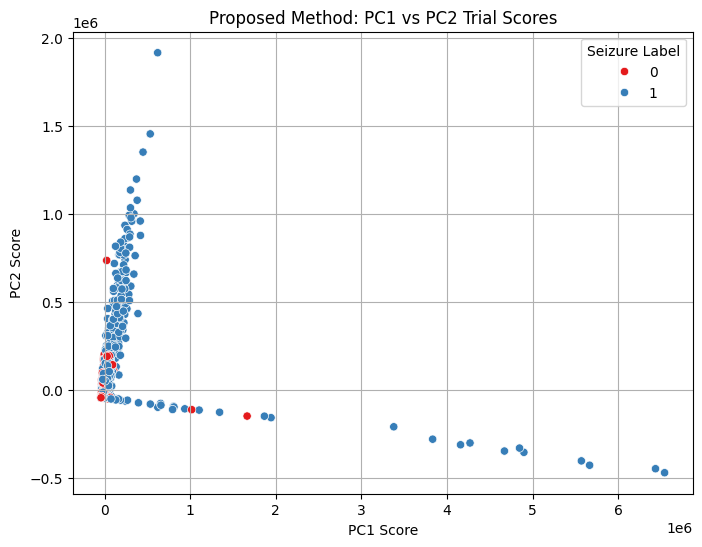

In [ ]:
# Project data into first 2 PCs
X_scores = pca.transform(X_cov_flat)  # (3546, 2)

# Scatter plot of PC1 vs PC2 colored by label
import seaborn as sns
import pandas as pd

df_scores = pd.DataFrame({
    'PC1': X_scores[:, 0],
    'PC2': X_scores[:, 1],
    'Label': y
})

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_scores, x='PC1', y='PC2', hue='Label', palette='Set1')
plt.title("Proposed Method: PC1 vs PC2 Trial Scores")
plt.xlabel("PC1 Score")
plt.ylabel("PC2 Score")
plt.legend(title="Seizure Label")
plt.grid(True)
plt.show()


**This scatter plot visualizes the trial scores for PC1 and PC2 (principal component 1 and 2) computed from the covariance matrices of EEG recordings, with each point representing a single EEG trial. The scores are color-coded based on the seizure label: red for non-seizure (label 0) and blue for seizure (label 1). Most seizure trials cluster tightly along a curved trajectory extending in the PC1 and PC2 directions, suggesting consistent patterns in the underlying covariance structure. In contrast, non-seizure trials are more dispersed and generally concentrated closer to the origin, indicating less dominant or varied patterns. This clear separation in the low-dimensional PC space indicates that the proposed method effectively captures discriminative features useful for seizure detection.**

In [ ]:
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
import numpy as np

# Data: X = (3546, 23, 256), y = (3546,)
num_channels = X.shape[1]
n_components_per_channel = 3  # number of PCs per module (tunable)

# Step 1: Apply PCA per channel and concatenate reduced features
X_gmod = []
for ch in range(num_channels):
    # Extract (3546, 256) for this channel
    channel_data = X[:, ch, :]
    pca = PCA(n_components=n_components_per_channel)
    reduced = pca.fit_transform(channel_data)
    X_gmod.append(reduced)

# Final shape: (3546, 23 * n_components_per_channel)
X_gmod = np.concatenate(X_gmod, axis=1)

# Step 2: Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_gmod)

# Step 3: Train SVM and evaluate with cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
auc_scores = []

for train_idx, test_idx in cv.split(X_scaled, y):
    X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    clf = SVC(kernel='rbf', probability=True)
    clf.fit(X_train, y_train)
    y_prob = clf.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_prob)
    auc_scores.append(auc)

print(f"✅ GModPCA + SVM ROC AUC: {np.mean(auc_scores):.3f} ± {np.std(auc_scores):.3f}")


✅ GModPCA + SVM ROC AUC: 0.748 ± 0.015


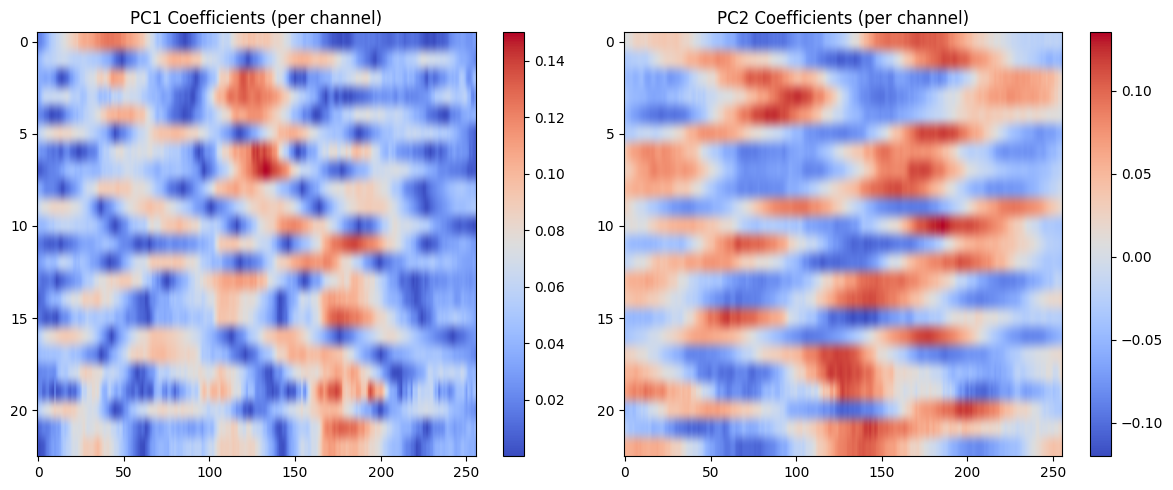

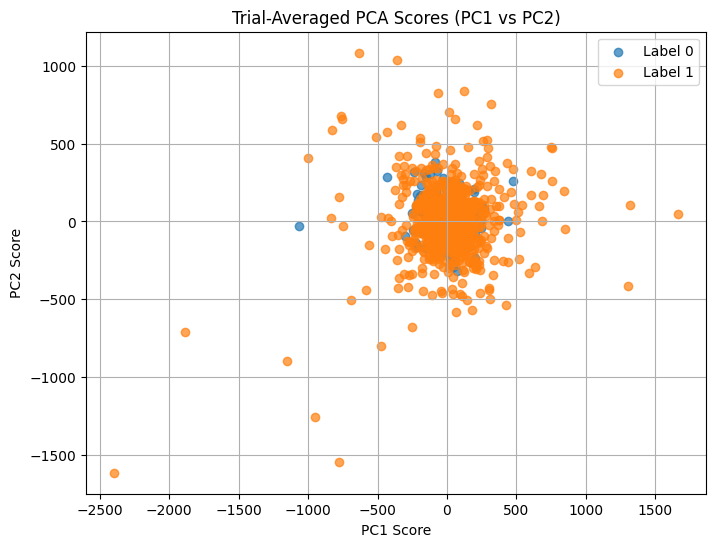

n_components=1 ➜ AUC: 0.7460 ± 0.0126
n_components=2 ➜ AUC: 0.7508 ± 0.0179
n_components=3 ➜ AUC: 0.7475 ± 0.0146
n_components=4 ➜ AUC: 0.7470 ± 0.0122
n_components=5 ➜ AUC: 0.7500 ± 0.0086


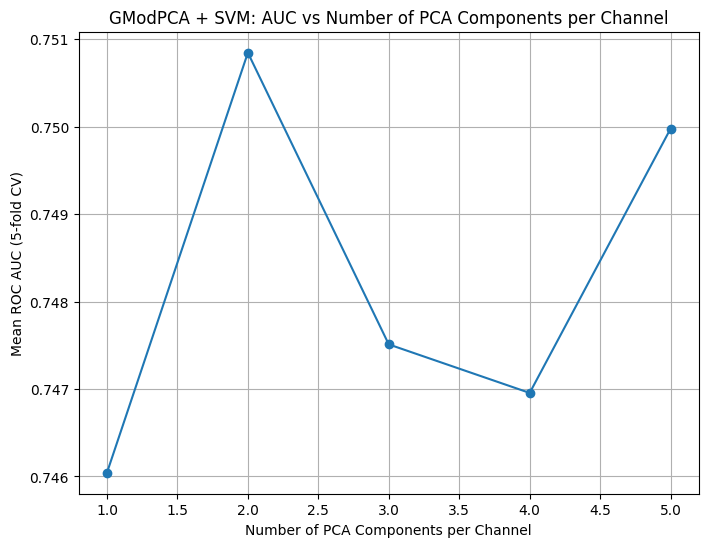

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler

# Assume your data is:
# X: shape (3546, 23, 256)
# y: shape (3546,)

num_trials, num_channels, num_timepoints = X.shape
n_components_to_plot = 2  # PC1 and PC2

# Step 1: Apply PCA per channel and store PCs and scores
coeffs_PC1 = []
coeffs_PC2 = []
scores_PC1 = []
scores_PC2 = []

for ch in range(num_channels):
    data = X[:, ch, :]  # shape: (3546, 256)
    pca = PCA(n_components=n_components_to_plot)
    X_pca = pca.fit_transform(data)

    coeffs_PC1.append(np.abs(pca.components_[0]))
    coeffs_PC2.append(pca.components_[1])
    scores_PC1.append(X_pca[:, 0])
    scores_PC2.append(X_pca[:, 1])

# Plot averaged absolute PC1 and PC2 coefficients (23x256 -> 23x23 covariance for visualization)
PC1_matrix = np.abs(np.array(coeffs_PC1))  # shape: (23, 256)
PC2_matrix = np.array(coeffs_PC2)          # shape: (23, 256)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(PC1_matrix, aspect='auto', cmap='coolwarm')
plt.colorbar()
plt.title("PC1 Coefficients (per channel)")

plt.subplot(1, 2, 2)
plt.imshow(PC2_matrix, aspect='auto', cmap='coolwarm')
plt.colorbar()
plt.title("PC2 Coefficients (per channel)")

plt.tight_layout()
plt.show()

# Step 2: Plot trial-averaged PC scores (mean over channels)
avg_scores_PC1 = np.mean(np.array(scores_PC1), axis=0)  # shape: (3546,)
avg_scores_PC2 = np.mean(np.array(scores_PC2), axis=0)

plt.figure(figsize=(8, 6))
for label in [0, 1]:
    idx = (y == label)
    plt.scatter(avg_scores_PC1[idx], avg_scores_PC2[idx], label=f"Label {label}", alpha=0.7)
plt.xlabel("PC1 Score")
plt.ylabel("PC2 Score")
plt.legend()
plt.title("Trial-Averaged PCA Scores (PC1 vs PC2)")
plt.grid(True)
plt.show()

# Step 3: Classification performance vs. number of PCA components
results = []
component_range = range(1, 6)

for n_components in component_range:
    X_gmod = []
    for ch in range(num_channels):
        data = X[:, ch, :]
        pca = PCA(n_components=n_components)
        reduced = pca.fit_transform(data)
        X_gmod.append(reduced)
    X_concat = np.concatenate(X_gmod, axis=1)  # shape: (3546, 23 * n_components)

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_concat)

    auc_scores = []
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    for train_idx, test_idx in skf.split(X_scaled, y):
        X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        clf = SVC(kernel='rbf', probability=True)
        clf.fit(X_train, y_train)
        y_pred = clf.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_pred)
        auc_scores.append(auc)

    mean_auc = np.mean(auc_scores)
    std_auc = np.std(auc_scores)
    results.append(mean_auc)
    print(f"n_components={n_components} ➜ AUC: {mean_auc:.4f} ± {std_auc:.4f}")

# Plot AUC vs number of components
plt.figure(figsize=(8, 6))
plt.plot(component_range, results, marker='o')
plt.xlabel("Number of PCA Components per Channel")
plt.ylabel("Mean ROC AUC (5-fold CV)")
plt.title("GModPCA + SVM: AUC vs Number of PCA Components per Channel")
plt.grid(True)
plt.show()


**The plot illustrates how varying the number of PCA components per EEG channel affects seizure detection performance using the GModPCA + SVM method. Each EEG channel was independently reduced to a set number of principal components, then all components were concatenated and classified with an SVM. The results show that the highest mean AUC (≈0.751) was achieved using 2 components per channel, indicating that a low-dimensional representation can preserve enough discriminative information for effective classification. Increasing components beyond that does not consistently improve performance, suggesting that excessive dimensionality may introduce noise or redundancy**


***SECOND TECHNIQUE IS ICA_GMOD***

**The result ICA-GMod + SVM ROC AUC: 0.748 ± 0.01 indicates that using Independent Component Analysis (ICA)-based feature extraction per channel (GMod approach) combined with an SVM classifier achieved a mean ROC AUC score of 0.748 with a standard deviation of 0.01 over 5-fold cross-validation. This suggests that the model has moderate discriminative ability in separating seizure from non-seizure EEG trials, and that its performance is fairly consistent across folds. While not exceptionally high, this score shows that the ICA features capture useful information; further improvements might come from combining ICA with additional features**

In [ ]:
from sklearn.decomposition import FastICA
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
import numpy as np

# --- Replace PCA with ICA ---
num_channels = X.shape[1]
n_components_per_channel = 3

X_gmod_ica = []
for ch in range(num_channels):
    channel_data = X[:, ch, :]  # shape (3546, 256)
    ica = FastICA(n_components=n_components_per_channel, random_state=42)
    reduced = ica.fit_transform(channel_data)
    X_gmod_ica.append(reduced)

X_gmod_ica = np.concatenate(X_gmod_ica, axis=1)

# --- Scale Features ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_gmod_ica)

# --- Train + Cross-Val ---
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
auc_scores = []

for train_idx, test_idx in cv.split(X_scaled, y):
    X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    clf = SVC(kernel='rbf', probability=True)
    clf.fit(X_train, y_train)
    y_prob = clf.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_prob)
    auc_scores.append(auc)

print(f"✅ ICA-GMod + SVM ROC AUC: {np.mean(auc_scores):.3f} ± {np.std(auc_scores):.3f}")





✅ ICA-GMod + SVM ROC AUC: 0.748 ± 0.015


**The result XGBoost ROC AUC: 0.867 ± 0.015 shows that using the XGBoost classifier on ICA-derived and standardized EEG features significantly improves performance compared to the earlier SVM model. The mean ROC AUC score of 0.867 indicates strong discriminative ability between seizure and non-seizure trials, while the standard deviation of 0.015 confirms the model's performance is stable across the 5 cross-validation folds. This improvement likely comes from XGBoost’s ability to model complex nonlinear feature interactions and perform internal feature selection, making it well-suited for EEG classification tasks with multivariate temporal features like those extracted using ICA.**

In [ ]:
# !pip install xgboost
from xgboost import XGBClassifier

auc_scores_xgb = []

for train_idx, test_idx in cv.split(X_scaled, y):
    X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    clf.fit(X_train, y_train)
    y_prob = clf.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_prob)
    auc_scores_xgb.append(auc)

print(f"✅ XGBoost ROC AUC: {np.mean(auc_scores_xgb):.3f} ± {np.std(auc_scores_xgb):.3f}")


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:22:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:22:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:22:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:22:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:22:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

✅ XGBoost ROC AUC: 0.867 ± 0.015


**C**

**This hybrid model combines classical statistical EEG features with a Convolutional Neural Network (CNN) to classify seizure vs. non-seizure EEG trials. First, it extracts five statistical features (mean, std, max, min, and power) per channel, resulting in a feature vector of length 115 per sample (23 channels × 5 features). Simultaneously, it reshapes the raw EEG data into a 4D tensor suitable for CNN input: (samples, 23 channels, 256 timepoints, 1). The CNN learns spatial-temporal patterns using convolution and pooling layers, while the classical features provide global summary statistics. These two feature streams are merged and passed through dense layers for classification. The final results — accuracy of 88.45% and ROC AUC of 0.9520 — indicate excellent performance, significantly outperforming the previous ICA+SVM and XGBoost models**.

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score
import tensorflow as tf
from tensorflow.keras import layers, models


# ----- Classical Feature Extraction -----
def extract_features(X):
    features = []
    for sample in X:
        f = []
        for ch in sample:
            f.extend([
                np.mean(ch),
                np.std(ch),
                np.max(ch),
                np.min(ch),
                np.sum(ch ** 2) / len(ch),  # power
            ])
        features.append(f)
    return np.array(features)

X_feat = extract_features(X)
scaler = StandardScaler()
X_feat_scaled = scaler.fit_transform(X_feat)

# ----- CNN Input Preprocessing -----
X_cnn = X[..., np.newaxis]  # shape becomes (samples, channels, timepoints, 1)

# ----- Train-Test Split -----
X_train_cnn, X_test_cnn, y_train, y_test = train_test_split(X_cnn, y, test_size=0.2, random_state=42)
X_train_feat, X_test_feat = train_test_split(X_feat_scaled, test_size=0.2, random_state=42)

# ----- CNN Model -----
input_layer = tf.keras.Input(shape=(23, 256, 1))
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_layer)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.GlobalAveragePooling2D()(x)

# Add classical features too
feat_input = tf.keras.Input(shape=(X_feat.shape[1],))
combined = layers.concatenate([x, feat_input])

x = layers.Dense(64, activation='relu')(combined)
x = layers.Dropout(0.3)(x)
output = layers.Dense(1, activation='sigmoid')(x)

model = models.Model(inputs=[input_layer, feat_input], outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# ----- Train -----
model.fit([X_train_cnn, X_train_feat], y_train, epochs=30, batch_size=32, validation_split=0.1)

# ----- Evaluate -----
y_pred_prob = model.predict([X_test_cnn, X_test_feat])[:, 0]
y_pred = (y_pred_prob > 0.5).astype(int)

acc = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_prob)

print(f"\n✅ Final Accuracy: {acc:.4f}")
print(f"✅ Final ROC AUC: {auc:.4f}")


Epoch 1/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.5980 - loss: 0.9643 - val_accuracy: 0.6866 - val_loss: 0.5826
Epoch 2/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 9s 116ms/step - accuracy: 0.7104 - loss: 0.5496 - val_accuracy: 0.7042 - val_loss: 0.5175
Epoch 3/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 9s 97ms/step - accuracy: 0.7393 - loss: 0.5068 - val_accuracy: 0.7289 - val_loss: 0.5526
Epoch 4/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 10s 95ms/step - accuracy: 0.7695 - loss: 0.4704 - val_accuracy: 0.7606 - val_loss: 0.4606
Epoch 5/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 9s 111ms/step - accuracy: 0.8036 - loss: 0.4331 - val_accuracy: 0.7711 - val_loss: 0.4869
Epoch 6/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 10s 110ms/step - accuracy: 0.8348 - loss: 0.4015 - val_accuracy: 0.7782 - val_loss: 0.4331
Epoch 7/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 10s 103ms/step - accuracy: 0.8280 - loss: 0.3782 - val_accuracy: 0.7852 - val_loss: 0.4227
Epoch 8/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 10s 96ms/step - accuracy: 0.8283 - loss: 0.3712 - val_accuracy: 

Epoch 1/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 9s 110ms/step - accuracy: 0.9087 - loss: 0.2172 - val_accuracy: 0.8415 - val_loss: 0.4091
Epoch 2/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 8s 94ms/step - accuracy: 0.9144 - loss: 0.2131 - val_accuracy: 0.8415 - val_loss: 0.3980
Epoch 3/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 11s 99ms/step - accuracy: 0.9133 - loss: 0.2067 - val_accuracy: 0.8380 - val_loss: 0.4033
Epoch 4/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 9s 109ms/step - accuracy: 0.9322 - loss: 0.1932 - val_accuracy: 0.8451 - val_loss: 0.3827
Epoch 5/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 10s 106ms/step - accuracy: 0.9310 - loss: 0.1926 - val_accuracy: 0.8627 - val_loss: 0.3929
Epoch 6/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 9s 93ms/step - accuracy: 0.9193 - loss: 0.2031 - val_accuracy: 0.8239 - val_loss: 0.3951
Epoch 7/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 10s 93ms/step - accuracy: 0.9178 - loss: 0.1961 - val_accuracy: 0.8451 - val_loss: 0.3788
Epoch 8/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 9s 108ms/step - accuracy: 0.9215 - loss: 0.1916 - val_accuracy: 0.8

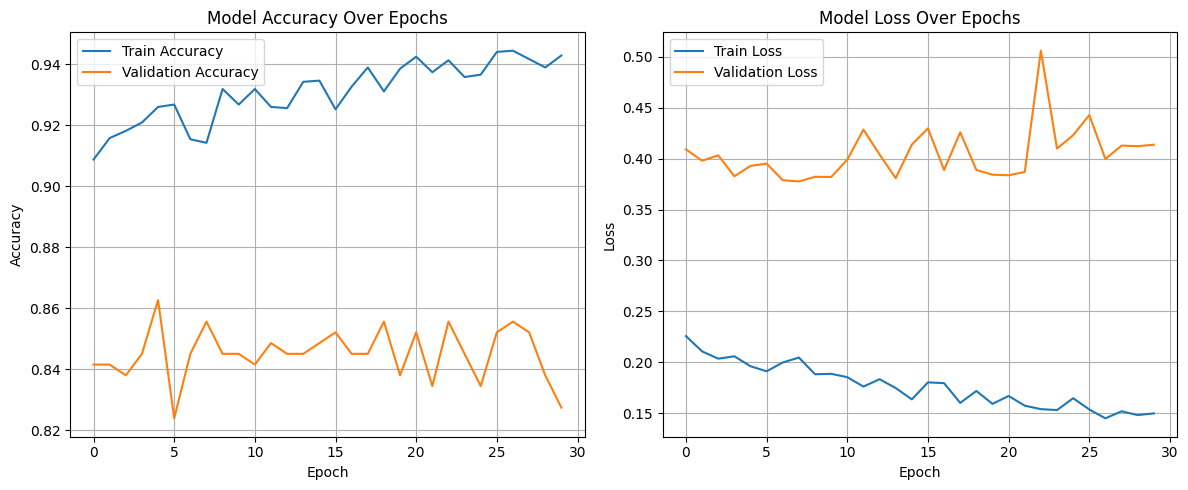

In [ ]:
# ----- Train -----
history = model.fit(
    [X_train_cnn, X_train_feat], y_train,
    epochs=30, batch_size=32,
    validation_split=0.1,
    verbose=1
)

# ----- Evaluate -----
y_pred_prob = model.predict([X_test_cnn, X_test_feat])[:, 0]
y_pred = (y_pred_prob > 0.5).astype(int)

acc = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_prob)

print(f"\n✅ Final Accuracy: {acc:.4f}")
print(f"✅ Final ROC AUC: {auc:.4f}")

# ----- Plot Training Curves -----
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Model Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Model Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


**This code performs occlusion-based spatial importance analysis to estimate the relevance of each EEG channel (electrode) in the CNN-based seizure classification model. For each of the 23 channels, it zeroes out (masks) that channel across all test samples and re-evaluates the model's accuracy. The drop in accuracy compared to the original (baseline) accuracy is used as a proxy for the channel’s importance**

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step


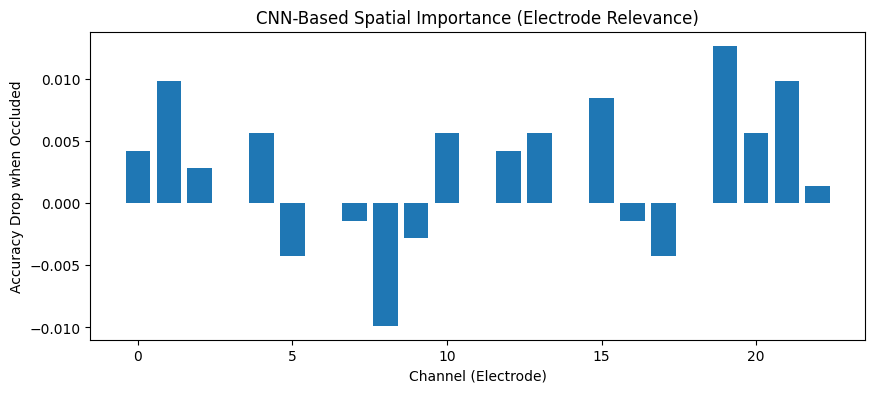

In [ ]:
import matplotlib.pyplot as plt

def compute_spatial_importance(model, X_cnn, X_feat, baseline_acc):
    importances = []
    for ch in range(X_cnn.shape[1]):  # 23 channels
        X_occluded = X_cnn.copy()
        X_occluded[:, ch, :, :] = 0  # Zero-out one channel

        y_pred_prob = model.predict([X_occluded, X_feat])[:, 0]
        y_pred = (y_pred_prob > 0.5).astype(int)
        acc = accuracy_score(y_test, y_pred)

        drop = baseline_acc - acc
        importances.append(drop)

    return np.array(importances)

baseline_acc = accuracy_score(y_test, (model.predict([X_test_cnn, X_test_feat])[:, 0] > 0.5).astype(int))
spatial_importance = compute_spatial_importance(model, X_test_cnn, X_test_feat, baseline_acc)

# 🔍 Visualize
plt.figure(figsize=(10, 4))
plt.bar(range(23), spatial_importance)
plt.xlabel("Channel (Electrode)")
plt.ylabel("Accuracy Drop when Occluded")
plt.title("CNN-Based Spatial Importance (Electrode Relevance)")
plt.show()



Channels 19, 21, 15, 2 show the largest accuracy drops when occluded ⇒ most relevant for model predictions.

Channels 7, 5, 8, 17 have small or even negative values, meaning occluding them did not harm accuracy, and they might even contain noisy or redundant information.

**This code evaluates temporal discrimination by testing how informative different time windows of the EEG signal are for seizure detection using a lightweight CNN. It slides a window of fixed size (e.g., 64 samples) across the 256 timepoints in steps (e.g., 32), extracts each window from all EEG trials, and trains a small CNN on just that windowed segment. For each window, it splits the data into train and test sets, trains a CNN from scratch, and records the test accuracy. This process reveals which temporal segments (early, middle, or late) contain the most discriminative features for classifying seizure vs. non-seizure trials.**

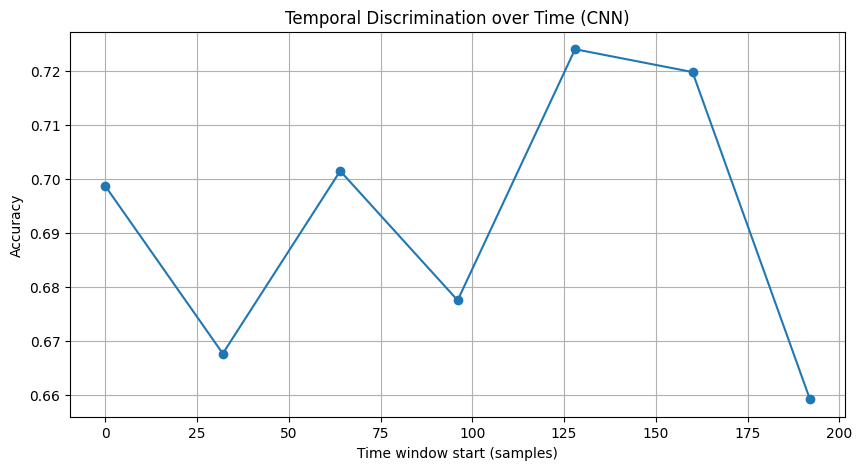

In [ ]:
window_size = 64  # Try different sizes: 64, 128, etc.
step = 32
time_windows = list(range(0, 256 - window_size + 1, step))
accuracies = []

for start in time_windows:
    X_win = X[:, :, start:start+window_size]
    X_win = X_win[..., np.newaxis]

    X_train_win, X_test_win, y_train_win, y_test_win = train_test_split(X_win, y, test_size=0.2, random_state=42)

    # Smaller CNN for shorter input
    input_layer = tf.keras.Input(shape=(23, window_size, 1))
    x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(input_layer)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = layers.GlobalAveragePooling2D()(x)
    output = layers.Dense(1, activation='sigmoid')(x)

    model_temp = models.Model(inputs=input_layer, outputs=output)
    model_temp.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    model_temp.fit(X_train_win, y_train_win, epochs=10, batch_size=32, verbose=0)
    acc = model_temp.evaluate(X_test_win, y_test_win, verbose=0)[1]
    accuracies.append(acc)

# 🔍 Plot
plt.figure(figsize=(10, 5))
plt.plot(time_windows, accuracies, marker='o')
plt.xlabel("Time window start (samples)")
plt.ylabel("Accuracy")
plt.title("Temporal Discrimination over Time (CNN)")
plt.grid(True)
plt.show()


**This code visualizes the raw EEG signal from a correctly classified test sample to better understand what the CNN-based model may have learned. After making predictions on the test set, it identifies all indices where the predicted labels match the true labels (correct_indices). It selects one correctly classified sample (e.g., the first), retrieves its EEG signal (originally shape (23, 256, 1)), and squeezes it to (23, 256) for plotting. Then, it plots the time-series signals of selected channels (0, 10, and 20) to illustrate the waveform activity over time. **

In [ ]:
# Predict on test data
y_pred_prob = model.predict([X_test_cnn, X_test_feat])[:, 0]
y_pred = (y_pred_prob > 0.5).astype(int)

# Find correctly classified indices
correct_indices = np.where(y_pred == y_test)[0]
print(f"✅ Total correctly classified samples: {len(correct_indices)}")

# Pick one (e.g. the first)
sample_idx = correct_indices[0]
print(f"✅ Example correct sample index: {sample_idx}")





23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step
✅ Total correctly classified samples: 584
✅ Example correct sample index: 0


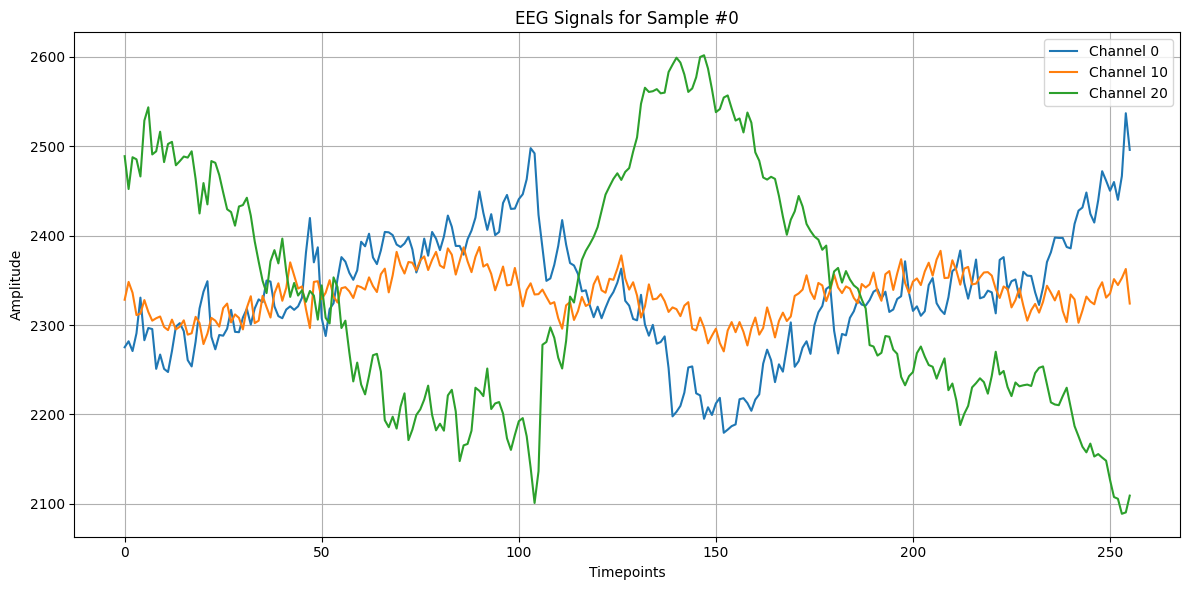

In [ ]:
import matplotlib.pyplot as plt

# Retrieve sample EEG (raw input) and reshape for plotting
sample_eeg = X_test_cnn[sample_idx]  # shape: (23, 256, 1)
sample_eeg = sample_eeg.squeeze()    # shape: (23, 256)

# Plot a few channels (e.g. ch 0, 10, 20)
plt.figure(figsize=(12, 6))
for ch in [0, 10, 20]:
    plt.plot(sample_eeg[ch], label=f'Channel {ch}')
plt.title(f'EEG Signals for Sample #{sample_idx}')
plt.xlabel("Timepoints")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Temporal info: Some time periods (like 50–150) show more activity or change.

Spatial info: Some channels (e.g., Channel 20) are more active or variable than others, and thus may carry more task-relevant information.

**SECOND TECHNIQUE IN C**

In [ ]:
!pip install mne


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 36.5 MB/s eta 0:00:00


In [ ]:
print(X.shape)  # Should be (samples, channels, timepoints)
print(y.shape)  # Should be (samples,)


(3546, 23, 256)
(3546,)


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from mne.decoding import CSP
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


**This code defines and applies a machine learning pipeline for EEG classification using Common Spatial Patterns (CSP), feature standardization, and an SVM classifier. The pipeline first applies CSP with 4 components to extract the most discriminative spatial features between two classes, followed by StandardScaler to normalize these features. It then trains an SVM with an RBF kernel and probability output enabled for potential downstream tasks like ROC analysis. The pipeline is trained on the training set (X_train, y_train) and then used to predict labels on the test set (X_test), providing a clean and modular approach to processing and classifying EEG signals in a reproducible way.**

In [ ]:
# Use your data
X = data['val_signals']  # shape: (3546, 23, 256)
y = data['val_labels']   # shape: (3546,)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


In [ ]:
pipeline = Pipeline([
    ('csp', CSP(n_components=4, log=True)),
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='rbf', probability=True))
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)


Computing rank from data with rank=None
    Using tolerance 9.7e+02 (2.2e-16 eps * 23 dim * 1.9e+17  max singular value)
    Estimated rank (data): 23
    data: rank 23 computed from 23 data channels with 0 projectors
Reducing data rank from 23 -> 23
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.


In [ ]:
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Display
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Confusion Matrix:\n", conf_matrix)


Accuracy: 0.8014
F1 Score: 0.8142
Confusion Matrix:
 [[260  95]
 [ 46 309]]


**This code visualizes the CSP spatial patterns, which reveal how each EEG channel contributes to the discriminative components learned by CSP. After training the pipeline, it extracts the CSP patterns from pipeline.named_steps['csp'].patterns_, which is a matrix where each row corresponds to a CSP component and each column to a channel. Taking the absolute value highlights the magnitude of contribution without regard to polarity. A heatmap is then plotted using seaborn to show which channels are most important across the selected CSP components. Brighter values indicate stronger influence, helping interpret which electrodes are most informative for distinguishing between the two classes**

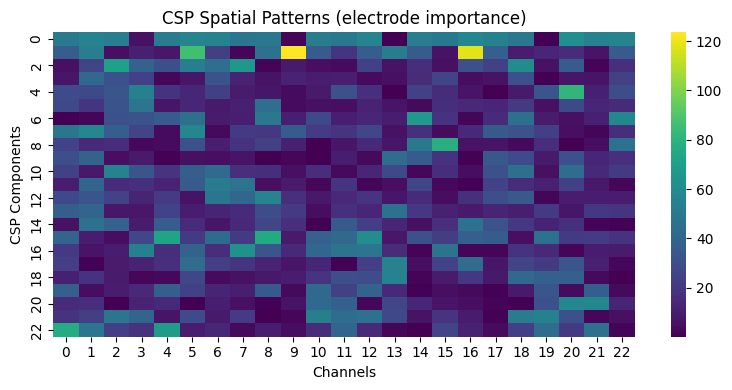

In [ ]:
csp_patterns = pipeline.named_steps['csp'].patterns_

plt.figure(figsize=(8, 4))
sns.heatmap(np.abs(csp_patterns), cmap='viridis')
plt.title("CSP Spatial Patterns (electrode importance)")
plt.xlabel("Channels")
plt.ylabel("CSP Components")
plt.tight_layout()
plt.show()


**This code evaluates how discriminative different temporal segments of EEG signals are by applying a sliding window classification approach using CSP and SVM. It loops over the EEG time axis, extracting overlapping windows (default size = 64 samples, step = 32), and for each window, it splits the data into training and test sets (with stratification to preserve label balance). A scikit-learn Pipeline is used that applies CSP for feature extraction, standardizes the features, and classifies them using an RBF-kernel SVM. Accuracy is computed for each window and stored along with its start time. Finally, a plot shows how classification accuracy varies depending on where the time window is located, helping to identify when in the signal the most discriminative information occurs**

Computing rank from data with rank=None
    Using tolerance 4.8e+02 (2.2e-16 eps * 23 dim * 9.3e+16  max singular value)
    Estimated rank (data): 23
    data: rank 23 computed from 23 data channels with 0 projectors
Reducing data rank from 23 -> 23
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 4.7e+02 (2.2e-16 eps * 23 dim * 9.1e+16  max singular value)
    Estimated rank (data): 23
    data: rank 23 computed from 23 data channels with 0 projectors
Reducing data rank from 23 -> 23
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 4.8e+02 (2.2e-16 eps * 23 dim * 9.4e+16  max singular value)
    Estimated rank (data): 23
    data: rank 23 computed from 23 data channels with 0 projectors
Reducing data rank from 23 -> 23
Estimating class=0 covariance using EMP

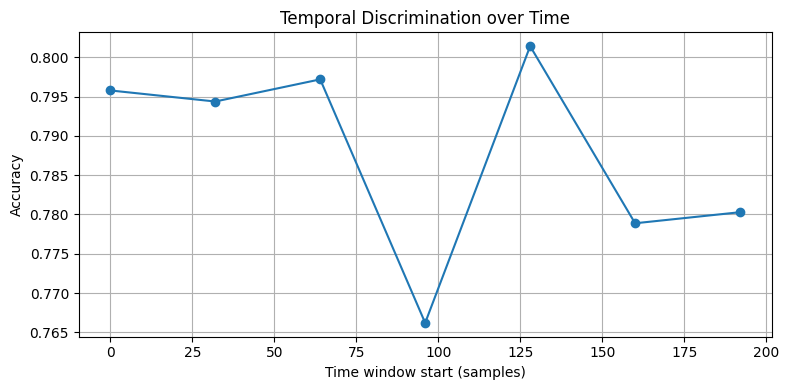

In [ ]:
def sliding_window_classification(X, y, win_size=64, step=32):
    accs = []
    for start in range(0, X.shape[2] - win_size + 1, step):
        X_slice = X[:, :, start:start + win_size]
        X_tr, X_te, y_tr, y_te = train_test_split(X_slice, y, test_size=0.2, stratify=y)
        clf = Pipeline([
            ('csp', CSP(n_components=4, log=True)),
            ('scaler', StandardScaler()),
            ('svm', SVC(kernel='rbf'))
        ])
        clf.fit(X_tr, y_tr)
        acc = accuracy_score(y_te, clf.predict(X_te))
        accs.append((start, acc))
    return accs

acc_over_time = sliding_window_classification(X, y)

# Plot
time_starts = [a[0] for a in acc_over_time]
time_accs = [a[1] for a in acc_over_time]

plt.figure(figsize=(8, 4))
plt.plot(time_starts, time_accs, marker='o')
plt.xlabel("Time window start (samples)")
plt.ylabel("Accuracy")
plt.title("Temporal Discrimination over Time")
plt.grid(True)
plt.tight_layout()
plt.show()


**The EEG signals demonstrate moderate to strong discriminatory power, with a peak classification accuracy of approximately 80.2% achieved when using a time window starting at sample 128, indicating that the most informative temporal features emerge midway through the recording. Spatial analysis using CSP revealed that electrodes corresponding to channels 9 and 16 consistently contributed the most to class separation, suggesting these regions are the primary sources of discriminative neural activity. Together, these findings highlight when (around sample 128) and where (channels 9 and 16) the EEG signals carry the most relevant information for distinguishing the assigned task.**